# Neural networks

In [155]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

## Load previously prepared data

In [156]:
df = pd.read_csv('data/laptop_train.csv')

In [157]:
df.head()

company  product  typename  inches  cpu  ram(GB)  gpu  opsys  weight(kg)  \
0        4      239         3    15.6   49        6   53      5        2.30   
1       10      291         1    15.6   58        8   75      5        2.50   
2        4      576         4    13.3   81        8   61      5        1.20   
3        2      602         4    13.3   38        8   46      5        1.20   
4        4      239         3    15.6   47        4   24      2        2.25   

   resolution  screentype  touchscreen  cpu(GHz)  memory_1_storage_gb  \
0           0           2            0       2.4               1000.0   
1           3           0            0       2.5                256.0   
2           3           2            0       1.8                256.0   
3           3           0            0       0.9                512.0   
4           0           2            0       2.0               1000.0   

   memory_1_type  memory_2_storage_gb  memory_2_type  log_price  
0              1                  0.0              3   6.129050  
1              3                  0.0              3   6.720220  
2              3                  0.0              3   7.364547  
3              3                  0.0              3   6.591674  
4              1                  0.0              3   6.143370

In [158]:
df.columns

Index(['company', 'product', 'typename', 'inches', 'cpu', 'ram(GB)', 'gpu',
       'opsys', 'weight(kg)', 'resolution', 'screentype', 'touchscreen',
       'cpu(GHz)', 'memory_1_storage_gb', 'memory_1_type',
       'memory_2_storage_gb', 'memory_2_type', 'log_price'],
      dtype='object')

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1132 non-null   int64  
 1   product              1132 non-null   int64  
 2   typename             1132 non-null   int64  
 3   inches               1132 non-null   float64
 4   cpu                  1132 non-null   int64  
 5   ram(GB)              1132 non-null   int64  
 6   gpu                  1132 non-null   int64  
 7   opsys                1132 non-null   int64  
 8   weight(kg)           1132 non-null   float64
 9   resolution           1132 non-null   int64  
 10  screentype           1132 non-null   int64  
 11  touchscreen          1132 non-null   int64  
 12  cpu(GHz)             1132 non-null   float64
 13  memory_1_storage_gb  1132 non-null   float64
 14  memory_1_type        1132 non-null   int64  
 15  memory_2_storage_gb  1132 non-null   f

In [160]:
target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

In [161]:
# en = LabelEncoder()
# for cols in catFeatures:
#     df[cols] = en.fit_transform(df[cols])
# print('Dataframe encoded by Label encoding dimension : ', df.shape)

In [162]:
df

company  product  typename  inches  cpu  ram(GB)  gpu  opsys  \
0           4      239         3    15.6   49        6   53      5   
1          10      291         1    15.6   58        8   75      5   
2           4      576         4    13.3   81        8   61      5   
3           2      602         4    13.3   38        8   46      5   
4           4      239         3    15.6   47        4   24      2   
...       ...      ...       ...     ...  ...      ...  ...    ...   
1127        7      111         3    14.0   52        4   47      5   
1128        0       77         3    15.6   57        8   86      5   
1129        7       27         3    15.6   73        8   53      5   
1130        7      324         3    15.6   10        6   29      5   
1131       10      456         3    15.6   57        8   53      5   

      weight(kg)  resolution  screentype  touchscreen  cpu(GHz)  \
0           2.30           0           2            0       2.4   
1           2.50           3           0            0       2.5   
2           1.20           3           2            0       1.8   
3           1.20           3           0            0       0.9   
4           2.25           0           2            0       2.0   
...          ...         ...         ...          ...       ...   
1127        1.54           3           2            0       2.3   
1128        2.40           3           2            0       2.5   
1129        2.04           0           2            0       2.7   
1130        2.04           3           2            0       2.9   
1131        2.30           3           0            0       2.5   

      memory_1_storage_gb  memory_1_type  memory_2_storage_gb  memory_2_type  \
0                  1000.0              1                  0.0              3   
1                   256.0              3                  0.0              3   
2                   256.0              3                  0.0              3   
3                   512.0              3                  0.0              3   
4                  1000.0              1                  0.0              3   
...                   ...            ...                  ...            ...   
1127                500.0              1                  0.0              3   
1128                256.0              3               1000.0              0   
1129               2000.0              1                  0.0              3   
1130               1000.0              2                  0.0              3   
1131               1000.0              1                  0.0              3   

      log_price  
0      6.129050  
1      6.720220  
2      7.364547  
3      6.591674  
4      6.143370  
...         ...  
1127   6.907755  
1128   6.683361  
1129   6.444131  
1130   6.309900  
1131   6.746013  

[1132 rows x 18 columns]

In [163]:
# One hot encoding
#dummLev = pd.get_dummies(df[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
#df = pd.concat([df[numericFeatures], dummLev, df[[target]]], axis=1)

#df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [164]:
#df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [165]:
features = df.columns.tolist()
features.remove(target)

In [166]:
df

company  product  typename  inches  cpu  ram(GB)  gpu  opsys  \
0           4      239         3    15.6   49        6   53      5   
1          10      291         1    15.6   58        8   75      5   
2           4      576         4    13.3   81        8   61      5   
3           2      602         4    13.3   38        8   46      5   
4           4      239         3    15.6   47        4   24      2   
...       ...      ...       ...     ...  ...      ...  ...    ...   
1127        7      111         3    14.0   52        4   47      5   
1128        0       77         3    15.6   57        8   86      5   
1129        7       27         3    15.6   73        8   53      5   
1130        7      324         3    15.6   10        6   29      5   
1131       10      456         3    15.6   57        8   53      5   

      weight(kg)  resolution  screentype  touchscreen  cpu(GHz)  \
0           2.30           0           2            0       2.4   
1           2.50           3           0            0       2.5   
2           1.20           3           2            0       1.8   
3           1.20           3           0            0       0.9   
4           2.25           0           2            0       2.0   
...          ...         ...         ...          ...       ...   
1127        1.54           3           2            0       2.3   
1128        2.40           3           2            0       2.5   
1129        2.04           0           2            0       2.7   
1130        2.04           3           2            0       2.9   
1131        2.30           3           0            0       2.5   

      memory_1_storage_gb  memory_1_type  memory_2_storage_gb  memory_2_type  \
0                  1000.0              1                  0.0              3   
1                   256.0              3                  0.0              3   
2                   256.0              3                  0.0              3   
3                   512.0              3                  0.0              3   
4                  1000.0              1                  0.0              3   
...                   ...            ...                  ...            ...   
1127                500.0              1                  0.0              3   
1128                256.0              3               1000.0              0   
1129               2000.0              1                  0.0              3   
1130               1000.0              2                  0.0              3   
1131               1000.0              1                  0.0              3   

      log_price  
0      6.129050  
1      6.720220  
2      7.364547  
3      6.591674  
4      6.143370  
...         ...  
1127   6.907755  
1128   6.683361  
1129   6.444131  
1130   6.309900  
1131   6.746013  

[1132 rows x 18 columns]

In [167]:
#X=df.drop('log_price', axis = 1).values
#y=df['log_price'].values

In [168]:
features = df.columns.tolist()
features.remove(target)

# Neural network

In [169]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn import metrics

In [170]:
x = df.drop('log_price', axis=1)
y = df['log_price']

In [171]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [172]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(792, 17)
(170, 17)
(170, 17)


In [173]:
sc=StandardScaler()

scaler = sc.fit(trainX)

trainX_scaled = scaler.transform(trainX)
valX_scaled = scaler.transform(valX)
testX_scaled = scaler.transform(testX)

In [174]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'ANN_2FC_F64_64_epoch_120'

In [175]:
input_shape = trainX.shape[1]

n_batch_size = 128

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 120


print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: 17
Batch Size: 128

Steps per Epoch: 6

Validation Steps: 1
Test Steps: 1

Number of Epochs: 120


In [205]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [206]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                1152      
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dense_134 (Dense)           (None, 64)                4160      
                                                                 
 dense_135 (Dense)           (None, 1)                 65        
                                                                 
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


In [207]:
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

In [208]:
checkpoint_dir = './'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [209]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

In [210]:
history = model.fit(trainX_scaled,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX_scaled, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/120
6/6 [==============================] - 2s 173ms/step - loss: 41.6270 - mae: 6.4047 - val_loss: 31.6528 - val_mae: 5.5433
Epoch 2/120
6/6 [==============================] - 1s 142ms/step - loss: 23.9281 - mae: 4.7623 - val_loss: 17.7750 - val_mae: 3.9876
Epoch 3/120
6/6 [==============================] - 1s 144ms/step - loss: 12.4564 - mae: 3.2543 - val_loss: 8.6171 - val_mae: 2.5896
Epoch 4/120
6/6 [==============================] - 1s 141ms/step - loss: 5.6839 - mae: 1.9855 - val_loss: 5.2372 - val_mae: 1.8778
Epoch 5/120
6/6 [==============================] - 1s 142ms/step - loss: 4.0280 - mae: 1.6423 - val_loss: 3.7109 - val_mae: 1.5931
Epoch 6/120
6/6 [==============================] - 1s 145ms/step - loss: 2.8905 - mae: 1.3587 - val_loss: 2.7895 - val_mae: 1.3941
Epoch 7/120
6/6 [==============================] - 1s 200ms/step - loss: 2.2032 - mae: 1.1965 - val_loss: 2.1629 - val_mae: 1.2031
Epoch 8/120
6/6 [==============================] - 1s 142ms/step - loss: 1.783

In [211]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

epoch       loss       mae   val_loss   val_mae
0      1  41.627048  6.404726  31.652792  5.543263
1      2  23.928120  4.762258  17.774973  3.987603
2      3  12.456367  3.254271   8.617093  2.589633
3      4   5.683879  1.985530   5.237187  1.877754
4      5   4.028008  1.642322   3.710943  1.593099

In [212]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

epoch     loss       mae  val_loss   val_mae
116    117  0.06077  0.199206  0.113738  0.239779

In [213]:
pk.dump(scaler, open(checkpoint_no + '/' + 'scaler.pkl', 'wb'))

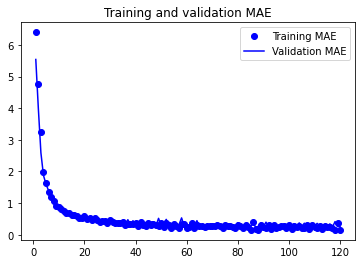

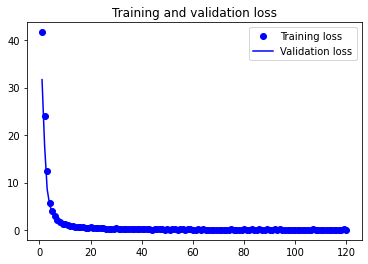

In [214]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## K-fold cross validation

In [215]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(input_shape,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model


In [216]:
k = 5
num_val_samples = len(trainX) // k

In [217]:
all_scores = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    print('MAE: ' + str(val_mae))
    print('----------------------')

Processing Fold 0
MAE: 0.2929545044898987
----------------------
Processing Fold 1
MAE: 0.2667238116264343
----------------------
Processing Fold 2
MAE: 0.31392064690589905
----------------------
Processing Fold 3
MAE: 0.28865838050842285
----------------------
Processing Fold 4
MAE: 0.2778300642967224
----------------------


In [218]:
for i, val in enumerate(all_scores):
    print('Fold ' + str(i) +': ' + 'MAE of', val)

Fold 0: MAE of 0.2929545044898987
Fold 1: MAE of 0.2667238116264343
Fold 2: MAE of 0.31392064690589905
Fold 3: MAE of 0.28865838050842285
Fold 4: MAE of 0.2778300642967224


In [219]:
print('Mean MAE of all folds: ' + str(np.mean(all_scores)))

Mean MAE of all folds: 0.28801748156547546


In [220]:
all_mae_histories = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing Fold 0
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4


In [221]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]

len(average_mae_history)

120

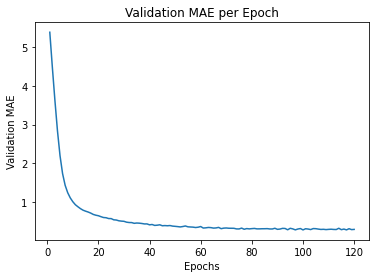

In [222]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [223]:
def smooth_curve(points, factor=0.9):
      '''
      Function for smoothing data points

      Args:
          points (float64): Array of floats to be smoothed, numpy array of floats

      Returns:
          Smoothed data points
      '''  
      smoothed_points = []
      for point in points:
        if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
        else:
          smoothed_points.append(point)
      return smoothed_points

In [224]:
n_first_observations_to_exclude = 30

smooth_mae_history = smooth_curve(average_mae_history[n_first_observations_to_exclude:])

smooth_mae_history = pd.DataFrame(smooth_mae_history)
smooth_mae_history = smooth_mae_history.set_index(smooth_mae_history.index + n_first_observations_to_exclude)
smooth_mae_history.head()

0
30  0.489379
31  0.488464
32  0.487497
33  0.484723
34  0.482996

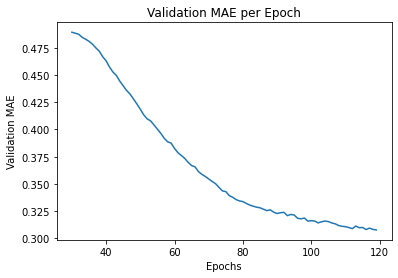

In [225]:
plt.plot(smooth_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [226]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [227]:
best_model = load_model(model_name_temp)

In [228]:
test_loss, test_mae = best_model.evaluate(testX_scaled,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test MAE:', test_mae)

1/1 [==============================] - 0s 111ms/step - loss: 0.1071 - mae: 0.2567

Test MAE: 0.2566562294960022


In [229]:
X = scaler.transform(df[features])

In [230]:
pred = model.predict(X)

36/36 [==============================] - 0s 1ms/step


In [231]:
df_Y = pd.DataFrame(df[target])
df_pred = pd.DataFrame(model.predict(X))

df_Y.reset_index(drop=True, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

df_results = pd.concat([df_Y, df_pred], axis=1)
df_results.columns = ['Actual', 'Predicted']

df_results

36/36 [==============================] - 0s 2ms/step


Actual  Predicted
0     6.129050   6.168833
1     6.720220   6.827619
2     7.364547   7.180570
3     6.591674   6.507847
4     6.143370   5.954983
...        ...        ...
1127  6.907755   6.340419
1128  6.683361   6.708959
1129  6.444131   6.306248
1130  6.309900   6.183661
1131  6.746013   6.466851

[1132 rows x 2 columns]

In [232]:
metrics.r2_score(df[target], pred)

0.7776325845091294

In [204]:
print('Mean Absolute Error:', metrics.mean_absolute_error(df[target], pred))
print('Mean Squared Error:', metrics.mean_squared_error(df[target], pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(df[target], pred, squared=False))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(df[target], pred))

Mean Absolute Error: 0.19128340971782043
Mean Squared Error: 0.08156991520304348
Root Mean Squared Error: 0.2856044733596508
Mean Absolute Percentage Error: 0.028279678888303985


## Save the model

Let's save the model. I will later compare the performance of different models on the testing dataset

In [233]:
model_reloaded.save("models/neural_network.h5")